## 0. Prepare your machine
You will use OpenCV to prepare a dataset and for SIFT-descriptior computation (for the second you need contrib libraries).

This particular contest was tested on Windows machine with

opencv-contrib-python==4.4.0.46
opencv-python==4.4.0.46

In [1]:
!pip install opencv-contrib-python opencv-python

## 1. Download the data
from this kaggle dataset. Unpack it to some folder.

Use the following code to read the data. The data will be stored in the following arrays:

X_train, X_test - lists of 2D np.arrays storing grayscaled images.
y_train, y_test - lists of text labels (alien, predator).

In [2]:
dataset_dir = "archive/data"

import cv2
import os

def load_dataset_part(folder):
    result = []
    for i in os.listdir(folder):
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
            result.append(img)
    return result


def load_dataset(folder, train=True):
    part = 'train' if train else 'validation'
    aliens = load_dataset_part(os.path.join(folder, part, 'alien'))
    predators = load_dataset_part(os.path.join(folder, part, 'predator'))
    X = aliens + predators
    y = ['alien'] * len(aliens) + ['predator'] * len(predators)
    return X, y
    
X_train, y_train = load_dataset(os.path.join(dataset_dir))
X_test, y_test = load_dataset(os.path.join(dataset_dir), train=False)

print(f"Train size {len(X_train)}, Test size {len(X_test)}")

Train size 694, Test size 200


alien


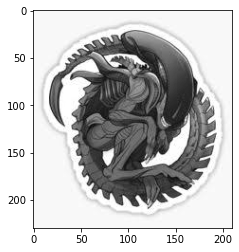

predator


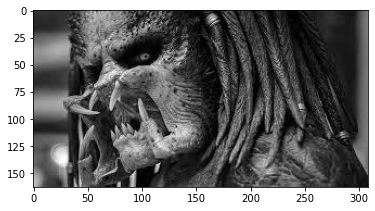

In [3]:
import matplotlib.pyplot as plt

print(y_train[13])
plt.imshow(X_train[13], cmap='gray')
plt.show()

print(y_train[-13])
plt.imshow(X_train[-13], cmap='gray')
plt.show()

## 2. Compute SIFT desciptors
Compute SIFT descriptors for every image. You can use detectAndCompute(...) method, please refer to documentation or, e.g. this tutorial.

NB Each image will produce unpredictable (different) number of SIFT vectors. Store them in matrices. Thus, your X_train_sift and X_test_sift will be lists of matrices (e.g. np.array's).

In [5]:
pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10

ERROR: Could not find a version that satisfies the requirement opencv-python==3.3.0.10
ERROR: No matching distribution found for opencv-python==3.3.0.10
Note: you may need to restart the kernel to use updated packages.


In [8]:
sift = cv2.SIFT_create()
X_train_sift = []
X_test_sift = []
for img in X_train:   
    kp, des = sift.detectAndCompute(img,None)
    X_train_sift.append(des)
for img in X_test:   
    kp, des = sift.detectAndCompute(img,None)
    X_test_sift.append(des)

In [10]:
X_train_sift[13].shape

(389, 128)

Some test about 13th image

In [9]:
assert X_train_sift[13].shape == (376, 128)
assert X_train_sift[13][0][0] == 84.0

AssertionError: 

## 3. Organize these vectors in the index (somehow)
I personally used the following strategy:

I numerate all vectors. labels array stores image index for a vector. | labels[idx]  == image # which owns the vector
Vector itself is a key, vector's index c thoughout all the vectors is value. | index[vector] == idx
Then, labels[c] will return image index. | labels[index[vector]] == image # for a vector
I query the index with a vector v and recieve c.
Thus, y_train[labels[c]] is a class of the images, described by the vector v.


In [11]:
from tqdm import tqdm
from annoy import AnnoyIndex
index = AnnoyIndex(128, 'angular')  

for idx in range(len(X_train_sift)):
    for vec in X_train_sift[idx]:
            index.add_item(idx, vec)
index.build(10)

True

## 4. Classification
Implement the best possible classifier function to your knowledge. Utilize all the data from the index and datasets. E.g.

if you set include_distances=True in Annoy search, it will also add distances in search results.
How many times each particular image was present in matches?
What about k-nn approach?
What about training a classifier based on vectors?
How about filtering out some useless vectors?
and so on...

In [12]:
from collections import Counter
def clf(vecs, index, classes, n=50):
    # my very simple classifier lived here. Can you do better?
    # write your code and change the method signature in pr
    ...
    pred = []
    for vec in vecs:
        for image_class in index.get_nns_by_vector(vec, n):
            pred.append(classes[image_class])
    counter=Counter(pred)
    idx = counter.most_common(1)
#     label = classes[predictio]
#     classes.append(labels[predictio])
    return idx[0][0]

## Test
Use these blocks to test your results. Pay attention to accuracy value. For me this is 0.74. You can definitely do better :)



In [15]:
from sklearn.metrics import classification_report
for k in [48]:
    predictions = []
    print(k)
    for sample in tqdm(X_test_sift):
        predictions.append(clf(sample, index, y_train,n=k))
    print(classification_report(y_test, predictions))

  4%|█▋                                         | 8/200 [00:00<00:02, 76.22it/s]

48


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.00it/s]

              precision    recall  f1-score   support

       alien       0.65      0.72      0.68       100
    predator       0.69      0.61      0.65       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200

